In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [2]:
test_image = cv2.imread("micro_test_files/1745176127617.jpg") 
# camera is upside down by default
test_image = cv2.rotate(test_image, cv2.ROTATE_180)
road_mask = cv2.imread("micro_test_files/road_mask.png")

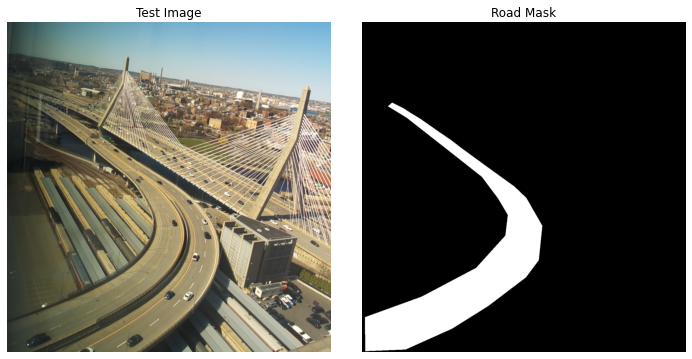

In [3]:
# Plot the test image and the test image and the road mask side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Test Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_mask, cv2.COLOR_BGR2RGB))
plt.title("Road Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

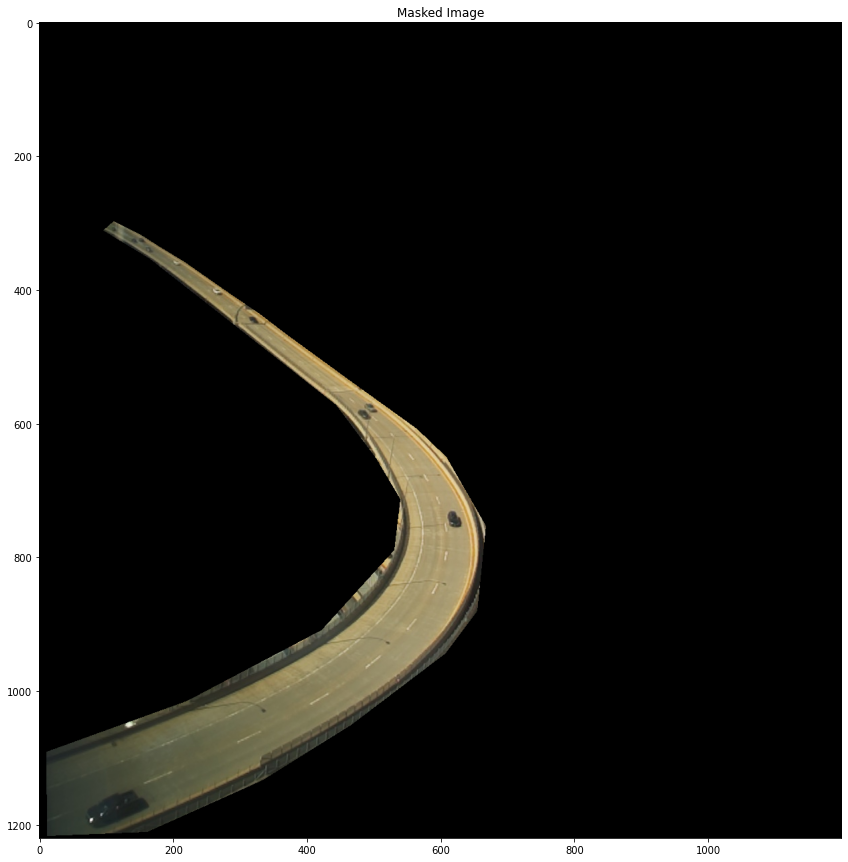

In [4]:
# Mask the test image with the road mask and trim to 200:height, 0:650
h,w = road_mask.shape[:2]
masked_image = cv2.bitwise_and(test_image, road_mask)
#masked_image = masked_image[250:h, 0:650]
# Show the masked image
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image")
#plt.axis("off")
plt.show()

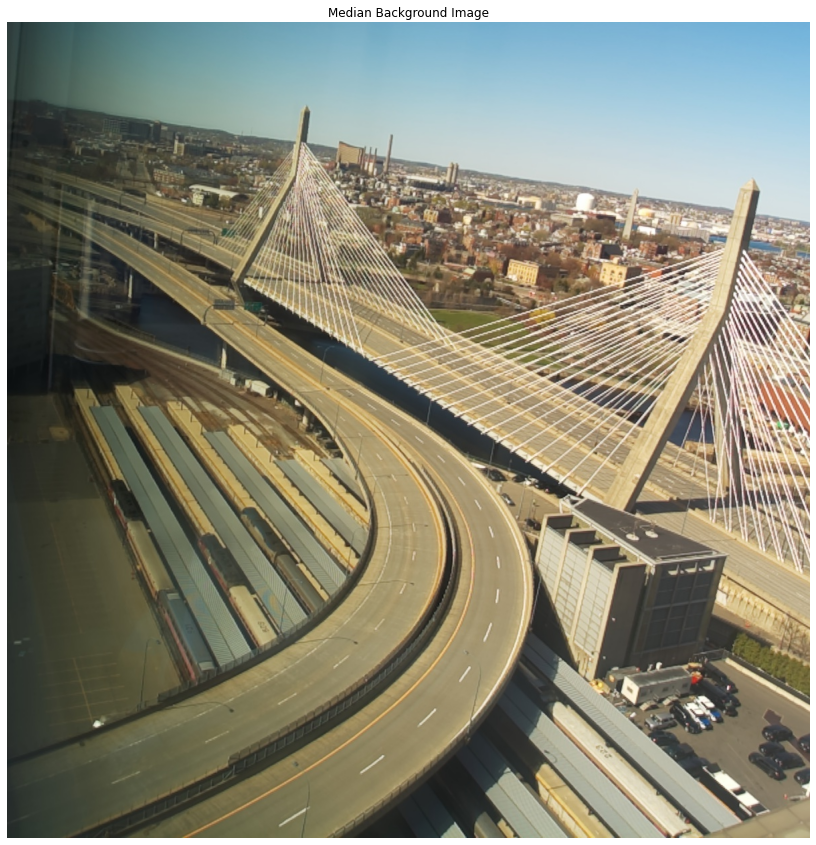

In [6]:
# load the median background image
median_bg = cv2.imread("median_bg.jpg")
# camera is upside down by default
median_bg = cv2.rotate(median_bg, cv2.ROTATE_180)
# Show the median background image
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(median_bg, cv2.COLOR_BGR2RGB))
plt.title("Median Background Image")
plt.axis("off")
plt.show()


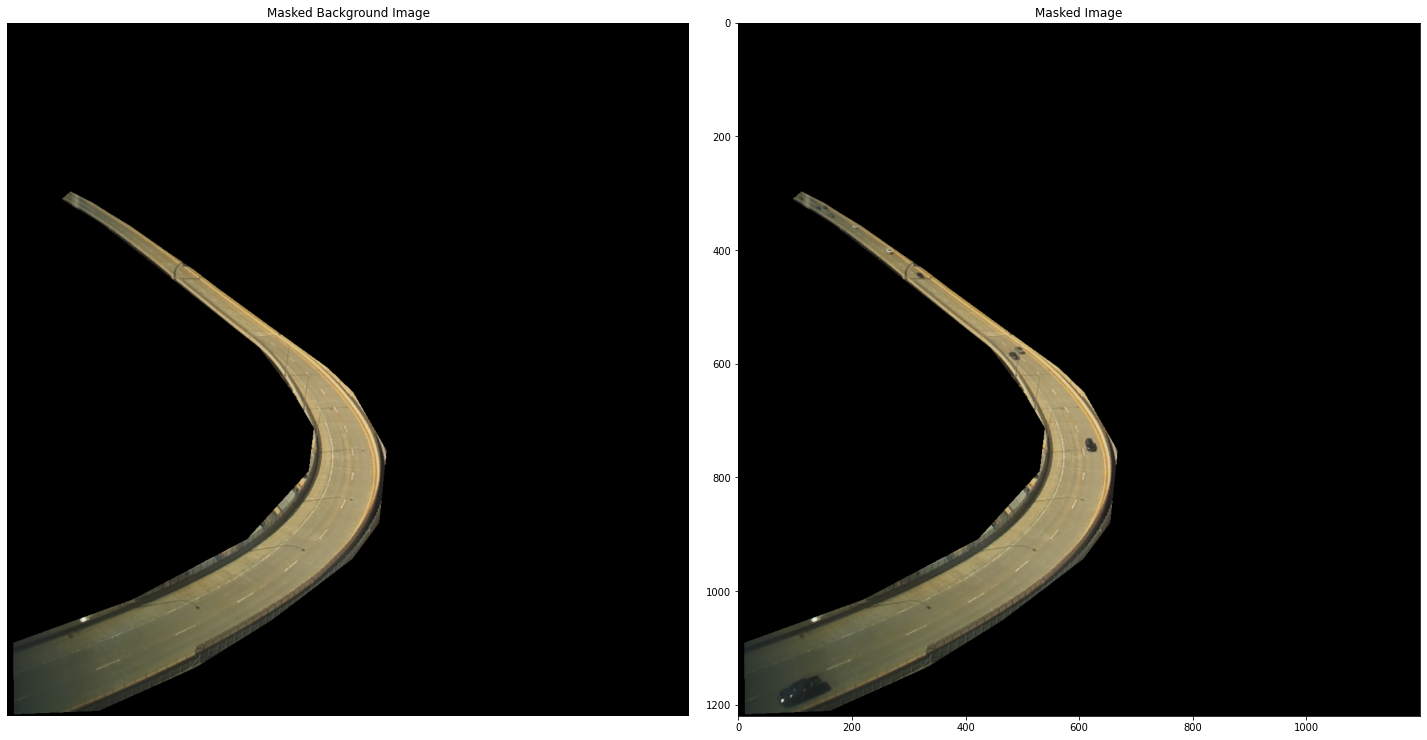

In [7]:
# mask the median background image with the road mask and trim to 200:height, 0:650
h,w = road_mask.shape[:2]
masked_bg = cv2.bitwise_and(median_bg, road_mask)
#masked_bg = masked_bg[250:h, 0:650]
# Show the masked background image and the masked image side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(masked_bg, cv2.COLOR_BGR2RGB))
plt.title("Masked Background Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image")
#plt.axis("off")
plt.tight_layout()
plt.show()

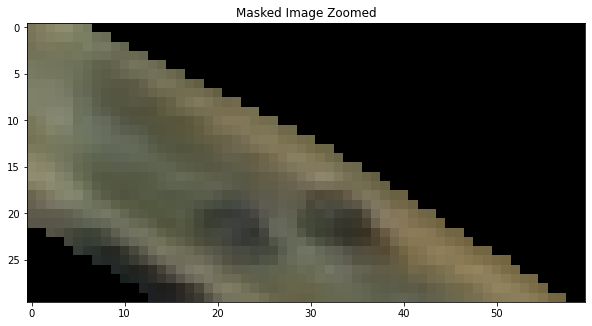

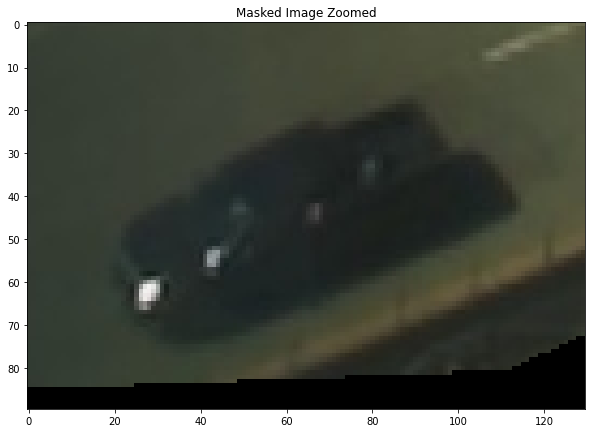

In [8]:
# show the masked image over the range 0:255
masked_image_zoomed_top = masked_image[55+250:85+250, 120:180]
masked_image_zoomed_bottom = masked_image[880+250:980+250, 50:180]
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(masked_image_zoomed_top, cv2.COLOR_BGR2RGB))
plt.title("Masked Image Zoomed")
#plt.axis("off")
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(masked_image_zoomed_bottom, cv2.COLOR_BGR2RGB))
plt.title("Masked Image Zoomed")
#plt.axis("off")
plt.show()

[441, 882]


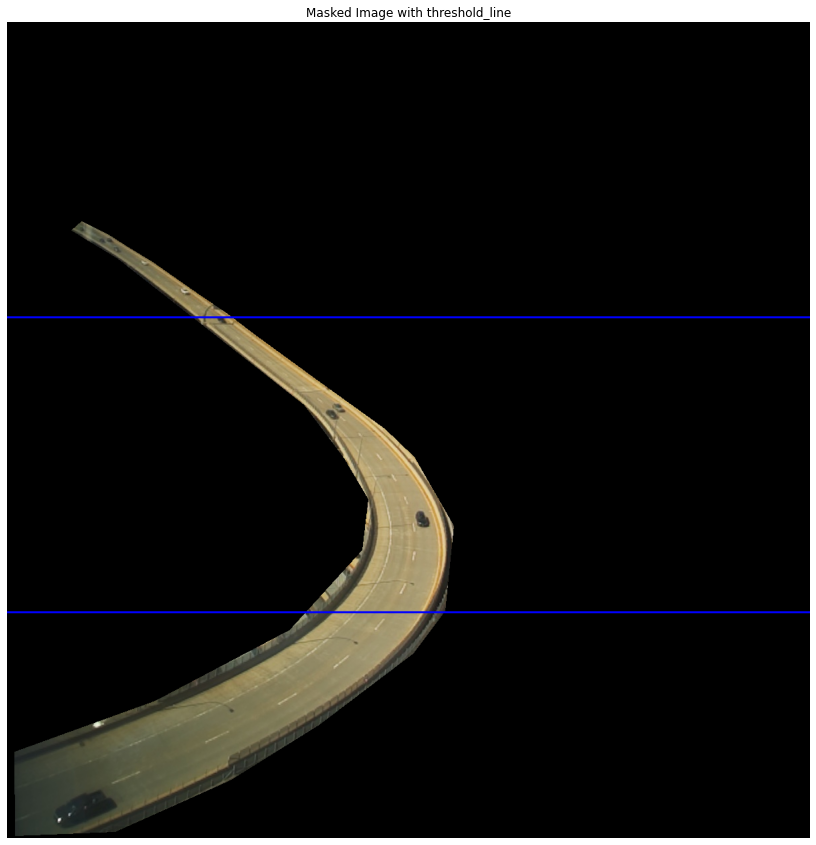

In [16]:

H, W = masked_image.shape[:2]
threshold_line = [int(0.3*(H+250)), int(0.6*(H+250))] 
print(threshold_line) 
masked_image_with_threshold_line = masked_image.copy()
# draw horizontal lines on the masked image
for cut in threshold_line:
    cv2.line(masked_image_with_threshold_line, (0, cut), (W, cut), (255, 0, 0), 2)
# Show the masked image with the threshold_line
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(masked_image_with_threshold_line, cv2.COLOR_BGR2RGB))
plt.title("Masked Image with threshold_line")
plt.axis("off")
plt.show()

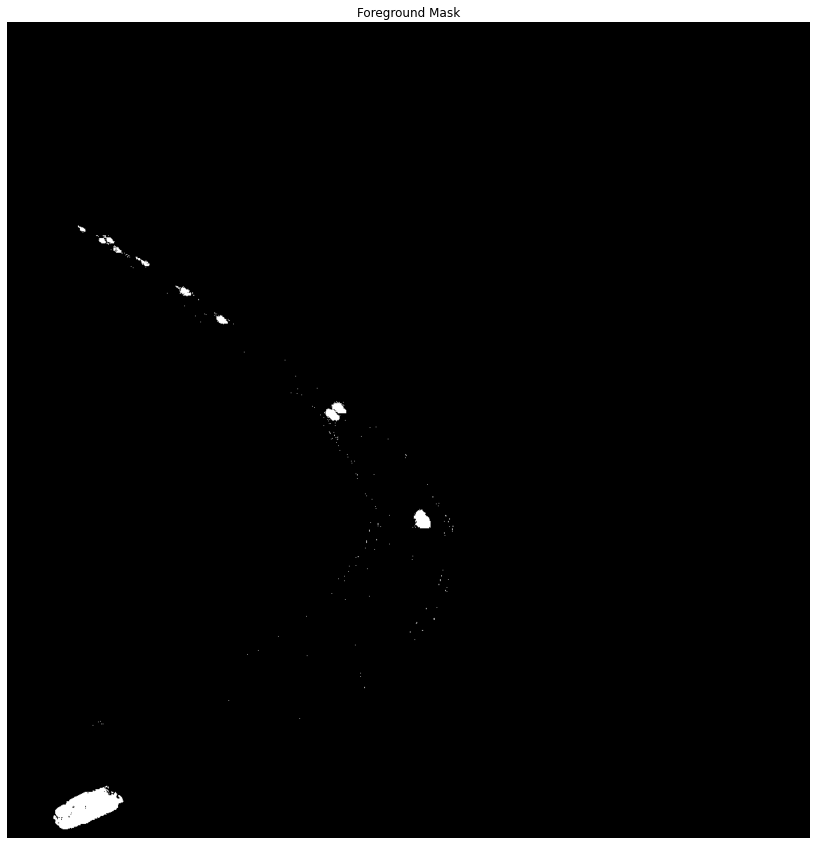

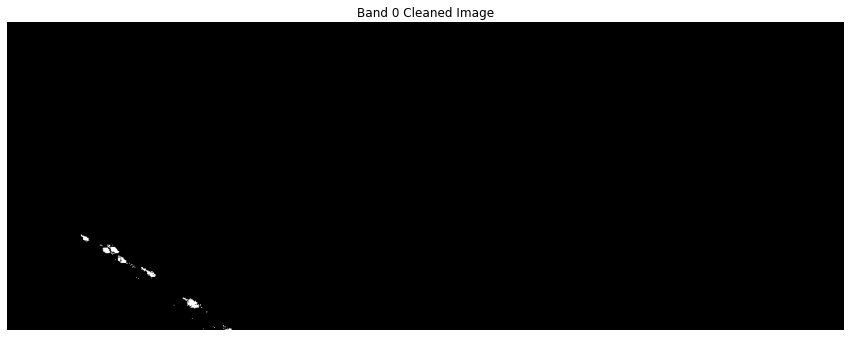

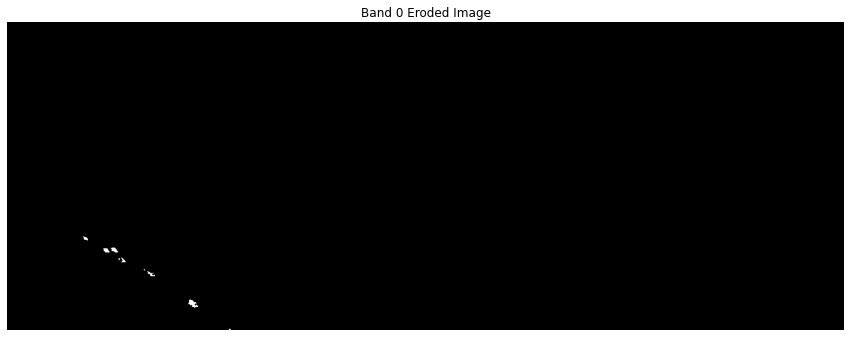

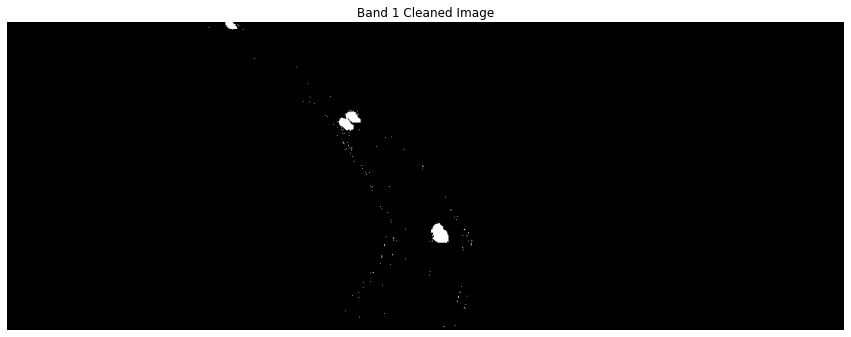

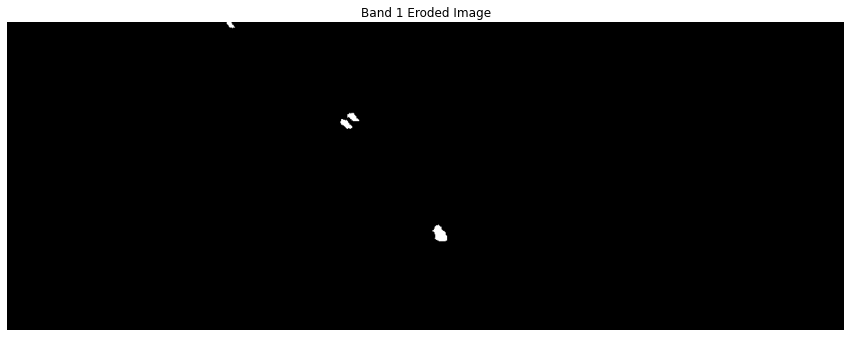

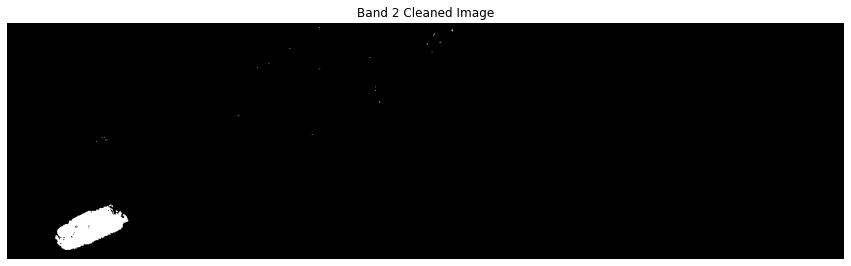

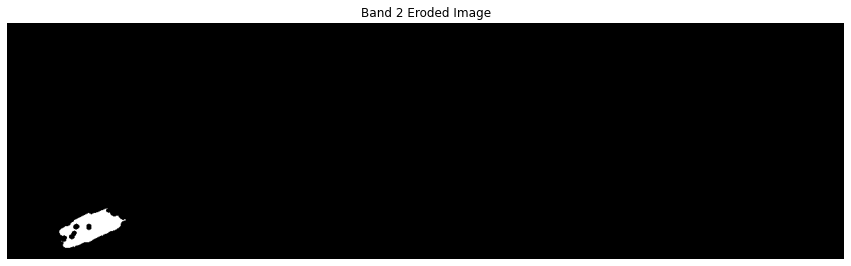

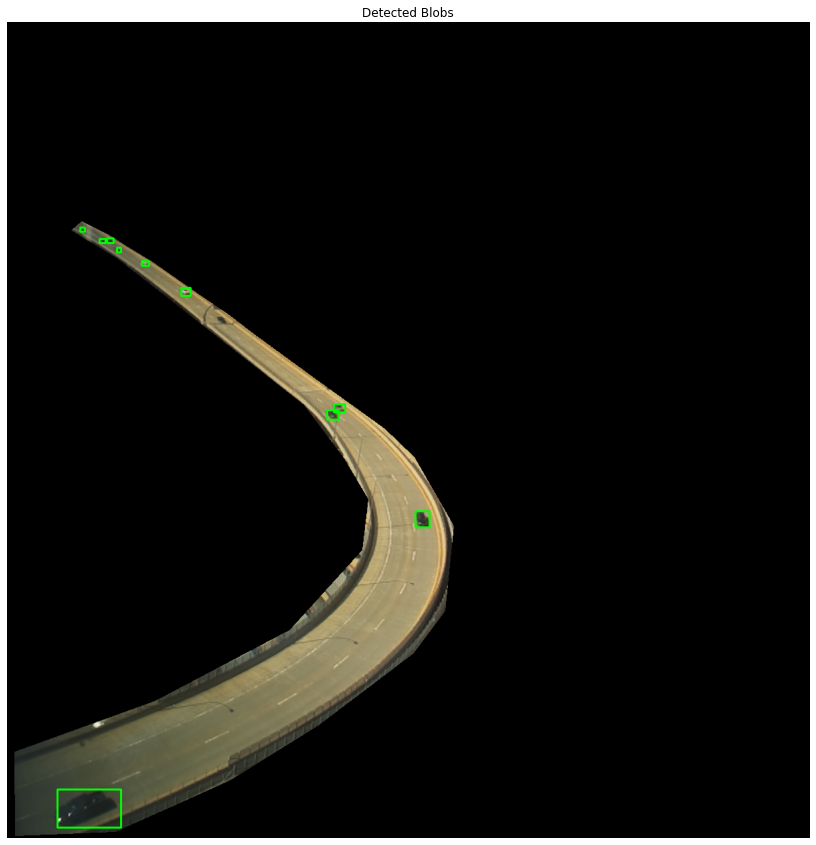

In [17]:

def detect_multiscale_blobs(
    fgmask: np.ndarray,
    cuts: list[float] = [0.25, 0.75],
    min_areas: list[int] = [10, 200, 1000],
    kernels: list[np.ndarray] = None
) -> list[tuple[int,int,int,int]]:
    """
    fgmask   : binary foreground mask (H×W)
    cuts     : either fractions of H (e.g. [0.25,0.75]) or absolute Y pixels ([y1,y2])
    min_areas: minimum w*h in each band
    kernels  : list of 3 structuring elements (one per band)
    """
    H, W = fgmask.shape[:2]

    # ——— interpret cuts as fractions if <1.0 ———
    if any(c <= 1.0 for c in cuts):
        cuts_px = [int(c * H) for c in cuts]
    else:
        cuts_px = cuts
    cuts_px = sorted(cuts_px)

    # ——— default morphology kernels if none passed ———
    if kernels is None:
        kernels = [
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)),
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)),
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)),
        ]

    detections = []

    # process each band separately
    bands = [ (0, cuts_px[0]),
              (cuts_px[0], cuts_px[1]),
              (cuts_px[1], H) ]



    for band_idx, (y0, y1) in enumerate(bands):
        roi = fgmask[y0:y1, :]
        # clean up the mask in this band
        #cleaned = cv2.morphologyEx(roi, cv2.MORPH_OPEN,  kernels[band_idx], iterations=1)
        #cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernels[band_idx], iterations=2)

        # show the cleaned image
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"Band {band_idx} Cleaned Image")
        plt.axis("off")
        plt.show()

        # inside your per‐band loop, before findContours():
        eroded = cv2.erode(roi, kernels[band_idx], iterations=1)
        restored = cv2.dilate(eroded, kernels[band_idx], iterations=1)

        # show the erorded image
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(eroded, cv2.COLOR_BGR2RGB))
        plt.title(f"Band {band_idx} Eroded Image")
        plt.axis("off")
        plt.show()

        # find contours in the cleaned band
        cnts, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in cnts:
            x, y_rel, w, h = cv2.boundingRect(cnt)
            area = w * h
            if area < min_areas[band_idx]:
                continue

            # convert y back to full‐image coords
            y = y0 + y_rel
            detections.append((x, y, w, h))

    return detections


diff = cv2.absdiff(masked_image, masked_bg)
gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
_, fgmask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

# Show the foreground mask
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(fgmask, cv2.COLOR_BGR2RGB))
plt.title("Foreground Mask")
plt.axis("off")
plt.show()


dets = detect_multiscale_blobs(fgmask, cuts=threshold_line)
output_image = masked_image.copy()
# draw rectangles around the detected blobs
for (x,y,w,h) in dets:
    cv2.rectangle(output_image, (x,y), (x+w,y+h), (0,255,0), 2)
# Show the test image with the detected blobs
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Blobs")
plt.axis("off")
plt.show()


In [11]:
# save masked_image
cv2.imwrite("masked_image.jpg", masked_image)

True